# Računalniški vid v robotiki

Da uspešno opravite vajo, jo morate predstaviti asistentu na vajah. Pri nekaterih nalogah so vprašanja, ki zahtevajo skiciranje, ročno računanje in razmislek. Končno rešitev na takšna vprašanja vpišite v predvideni prostor, postopek reševanja pa razložite asistentu na vajah. Deli nalog, ki imajo pred navodilom navedene točke, niso obvezni. Brez njih lahko za celotno vajo dobite največ **75** točk (zgornja meja je **100** točk kar pomeni oceno 10). V nekaterih vajah je dodatnih nalog več in vam ni potrebno opraviti vseh.

Zaključna vaja povezuje robotiko in računalniško zaznavanje. Vaš robotski sistem boste nadgradili s kamero, ki bo opazovala delovno površino robotskega manipulatorja, preko zajete slike pa boste lahko na površini zaznali objekte glede na njihovo barvo in obliko. Preko homografske preslikave boste točke iz koordinatnega prostora slike pretvorili v prostor robota ter mu ukazali, naj se premakne tako, da pokaže na ustrezni predmet.

In [2]:
import cv2
import manus
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

%matplotlib notebook

In [4]:
# Run this cell to download the data used in this exercise
import zipfile, urllib.request, io
zipfile.ZipFile(io.BytesIO(urllib.request.urlopen("https://data.vicos.si/lukacu/rrz/vaja4.zip").read())).extractall()

## Naloga 1 - Homografska transformacija

Homografska transformacija je pogosto uporabljana v projektivni geometriji. Predstavlja projekcijo ene ravnine v prostoru na drugo ravnino v prostoru. Naj bo $\mathbf{x}_w$ točka na ravnini v svetovnih koordinatah in naj bo $\mathbf{x}_c$ točka v koordinatah slikovne ravnine. Natančneje, $\mathbf{x}_w=[ x_w, y_w, 1 ]^T$ in $\mathbf{x}_c=[ x_c, y_c, 1 ]^T$. Projekcijo točke svetovnih koordinatah $\mathbf{x}_w$ v točko $\mathbf{x}_c$, ki se nahaja na slikovni ravnini senzorja, preslikamo s homografijo $\mathbf{H}_w^c$ po enačbi

$$
    \mathbf{x}_c = \lambda \mathbf{H}_w^c \mathbf{x}_w,
$$

kjer je homografija matrika velikosti $3 \times 3$ elementov

$$
    \mathbf{H}_w^c = \left[ {\begin{array}{}
{{h_{11}}}&{{h_{12}}}&{{h_{13}}}\\
{{h_{21}}}&{{h_{22}}}&{{h_{23}}}\\
{{h_{31}}}&{{h_{32}}}&{{h_{33}}}
\end{array}} \right] .
$$

Relacija v zgornji enačbi je zapisana v homogenih koordinatah in je zato napisana le do skale natančno. V praksi ima matrika $\mathbf{H}_w^c$ samo 8 *prostih* parametrov in ne 9, saj zadnji element postavimo na ena, $h_{33}=1$. Če hočemo točke v koordinatah slike $\mathbf{x}_c$ preslikati v točko $\mathbf{x}_c$, ki se nahaja na svetovnih koordinatah, moramo uporabiti inverz homografije $\mathbf{H}_c^w = (\mathbf{H}_w^c)^{-1}$.

V naslednjih nalogah boste preizkusili homografsko transformacijo na pripravljenih podatkih.

* Naložite sliko iz datoteke ``camera1.jpg`` ter homografsko matriko iz datoteke ``camera1.txt`` z uporabo spodaj priložene funkcije ``load_h``. Prikažite sliko ter na njej izrišite mrežo točk z desetimi vrsticami in desetimi stolpci.

In [2]:
def load_h(txt_file_path):
    with open(txt_file_path, 'r') as f:
        l = [[float(num) for num in line.split(',')] for line in f]    
    return np.array(l)

<IPython.core.display.Javascript object>


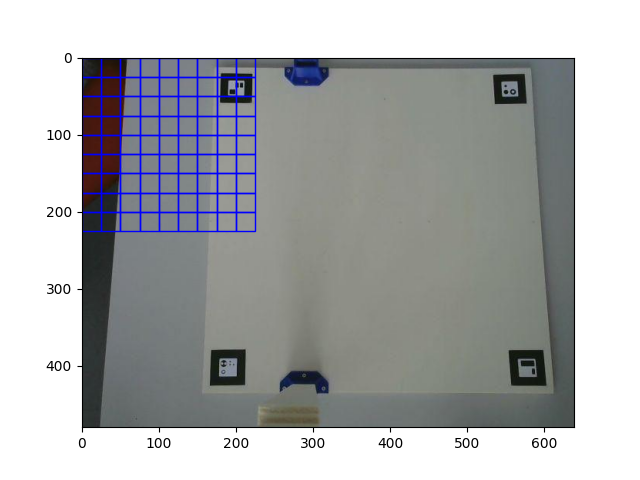

In [28]:
import matplotlib.patches as patches
h = load_h("camera1.txt")
img = cv2.imread("camera1.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(im)
coords = []
x = 0
y=0
for i in range(1,10):
    for j in range(1,10):
        rect = patches.Rectangle((x,y), 25, 25, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        x+=25
        coords.append((x,y))
    y+=25
    x=0
plt.show()


* Izris spremenite tako, da točke črt pred izrisom preslikate s prebrano homografsko matriko. Pri tem morate točke najprej preslikati v homografske koordinate (na konec vektorja dodati vrednost $1$), jo pomnožiti z matriko, nato pa *točko pretvoriti nazaj iz homogenih koordinat* tako, da vektor delimo z vrednostjo zadnjega elementa ter tega nato odstranimo. Spodaj je prikazan zaželeni rezultat, kjer plava mreža prikazuje rezultat zgornje naloge, rdeča mreža pa rezultat te naloge.

\begin{equation*}
p_S = [ x, y, 1 ], \\  p_H = H \ast p_S = [ x_H, y_H, z_H ], \\ p_D = \big[ \frac{x_H}{z_H}, \frac{y_H}{z_H} \big]
\end{equation*}

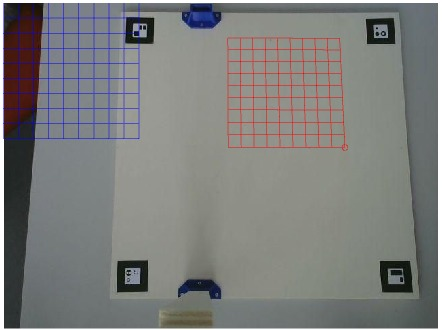

<IPython.core.display.Javascript object>


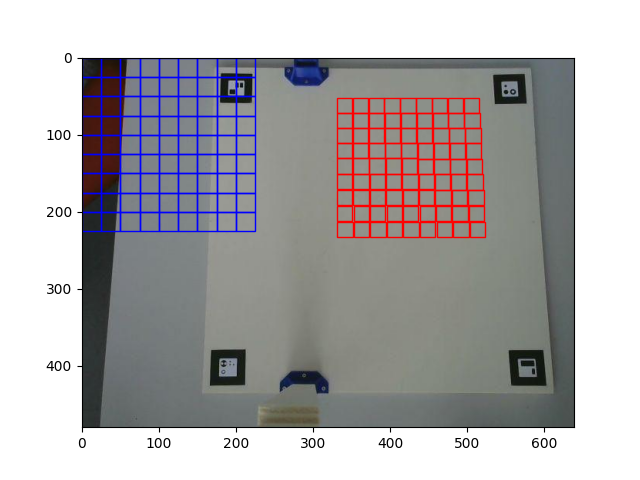

In [7]:

import matplotlib.patches as patches
h = load_h("camera1.txt")
img = cv2.imread("camera1.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(im)
coords = []
x = 0
y=0
for i in range(1,10):
    for j in range(1,10):
        rect = patches.Rectangle((x,y), 25, 25, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        coords.append((x,y))
        x+=25
    y+=25
    x=0
for i in coords:
    ps = np.array([i[0],i[1],1])
    ph = np.dot(h,ps)
    pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
    rect = patches.Rectangle((pd[0],pd[1]), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

* Oglejmo si sedaj še preslikavo v drugo smer. To tehniko lahko uporabimo za preslikavo iz slikovnih koordinat v svetovne koordinate. Matriko $H$ invertirajte z uporabo funkcije ``np.linalg.inv``. Prikažite sliko ter z uporabo funkcije ``ginput`` knjižnice *matplotlib* vnesite eno ali več točk s klikom na sliko. Dane točke preslikajte z uporabo inverza matrike $H$ iz ravnine kamere v svetovne koordinate ter jih prikažite v novem grafu z uporabo funkcije plot.

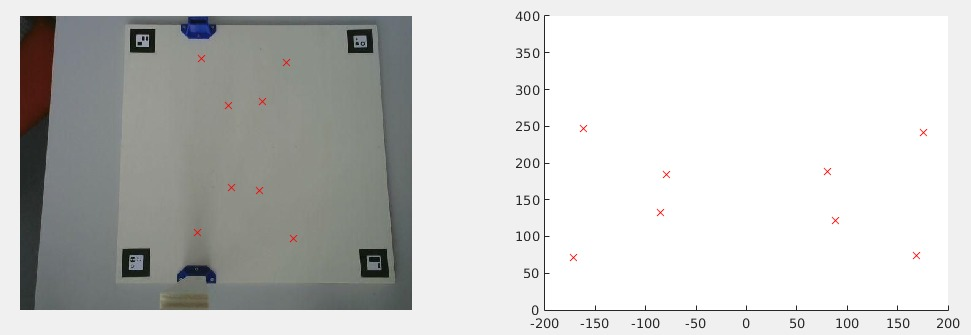

In [ ]:
# TODO
h = load_h("camera1.txt")
img = cv2.imread("camera1.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure()
plt.subplot(121)
plt.imshow(im)
x = plt.ginput(8,show_clicks=True)
hi = np.linalg.inv(h)
xx=[]
xy=[]
tx = []
ty = []
for i in x:
    xx.append(i[0])
    xy.append(i[1])
    ps = np.array([i[0],i[1],1])
    ph = np.dot(hi,ps)
    pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
    tx.append(pd[0])
    ty.append(pd[1])
plt.scatter(xx,xy,marker="+", c="r")
plt.subplot(122)
plt.scatter(ty,tx,marker="x",c="r")
plt.show()

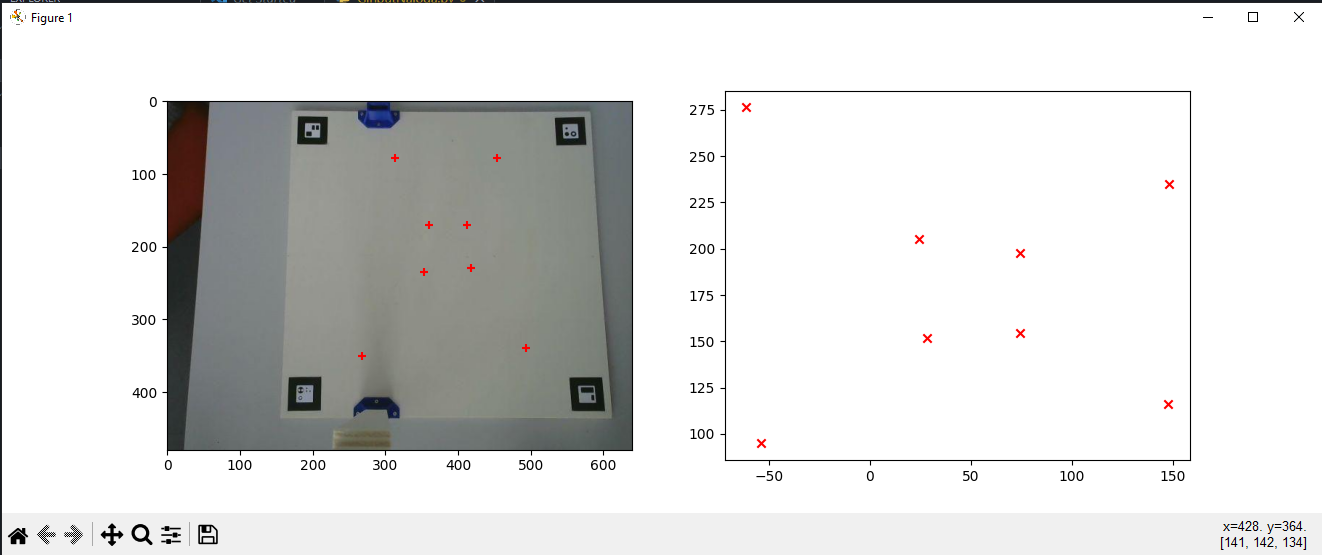

## Naloga 2 - Detekcija objektov

V tej nalogi boste implementirali preprosto detekcijo planarnih objektov z uporabo segmentacije, morfoloških operacij ter opisa regij. Sledite naslednjim korakom (*lahko si pomagate z detekcijo bombonov, če ste jo implementirali v okviru druge vaje*).

* Naložite sliko iz datoteke ``camera2.jpg`` ter jo prikažite na zaslonu. Z uporabo funkcije ``ginput`` določite meje poligona delovne površine kot je prikazano na spodnjem primeru. Nato za podane točke generirajte rastersko masko z uporabo funkcije ``poly2mask``, ki na vhodu sprejme koordinate poligona ter velikost rasteriziranega območja (za lažjo uporabo naj bo ta enaka velikosti slike). Če ste pri drugi vaji implementirali funkcijo ``immask``, jo sedaj uporabite za prikaz izolirane delovne površine.

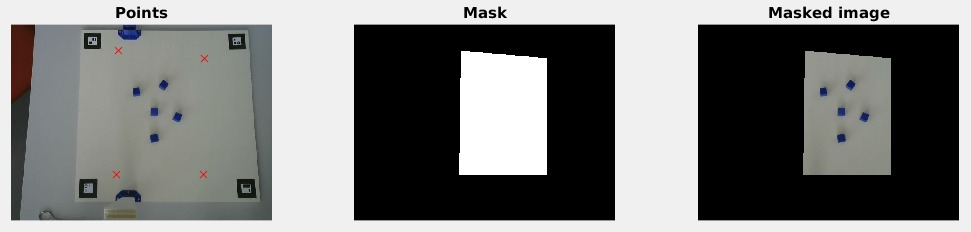

In [9]:
from skimage import draw
def poly2mask(y_coords, x_coords, shape):
    # y_coord = y koordinate poligona (vrstni red je pomemben!)
    # x_coord = x koordinate poligona (vrstni red je pomemben!)
    # shape = dimenzije maske (height, weight)
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

In [10]:
def im_mask(I, mask):
    # Zapišite rešitev tukaj
    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0
    
    return I_masked

In [ ]:
img = cv2.imread("camera2.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape
print(shape)
plt.figure()
plt.subplot(131)
plt.imshow(im)
x = plt.ginput(4,show_clicks=True)
x_c = []
y_c = []
for i in x:
    x_c.append(i[0])
    y_c.append(i[1])
plt.scatter(x_c,y_c,marker="+", c="r")
mask = poly2mask(np.array(y_c),np.array(x_c),shape)
plt.subplot(132)
plt.imshow(mask,cmap="gray")
plt.subplot(133)
imm = im_mask(im,mask)
plt.imshow(imm)
plt.show()

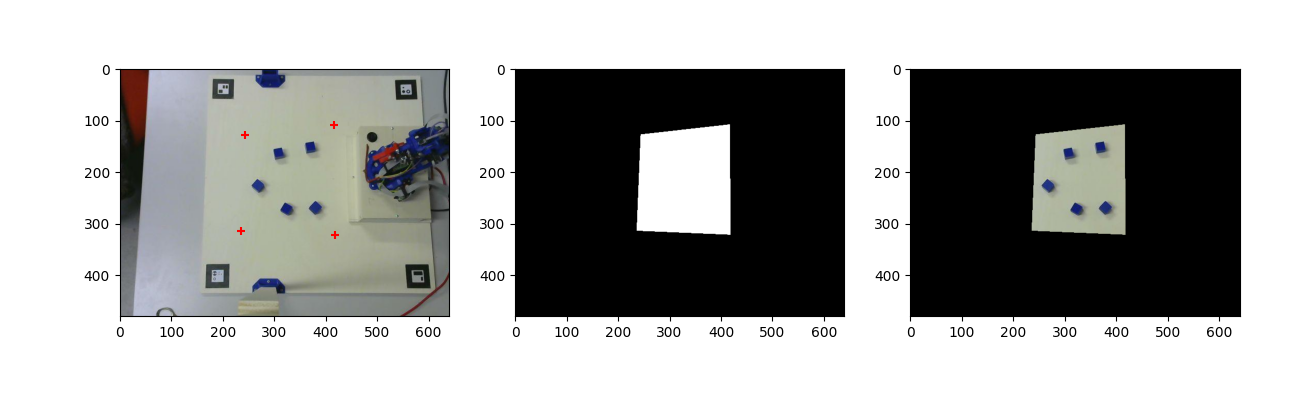

* Sliko pogleda kamere pretvorite v HSV barvni prostor ter z uporabo upragovanja določite regije modre barve. Po potrebi segmentacijo izboljšajte z uporabo morfoloških operacij *erode* in *dilate*, da se znebite šuma. Končno binarno masko združite z masko delovne površine, da odstranite morebitne napačne detekcije.

In [ ]:
from skimage import draw
import cv2
import manus
import numpy as np
import matplotlib.pyplot as plt
def poly2mask(y_coords, x_coords, shape):
    # y_coord = y koordinate poligona (vrstni red je pomemben!)
    # x_coord = x koordinate poligona (vrstni red je pomemben!)
    # shape = dimenzije maske (height, weight)
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask
def im_mask(I, mask):
    # Zapišite rešitev tukaj
    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0   
    return I_masked
img = cv2.imread("camera2.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape
print(shape)
plt.figure()
plt.subplot(131)
plt.imshow(im)
x = plt.ginput(4,show_clicks=True)
x_c = []
y_c = []
for i in x:
    x_c.append(i[0])
    y_c.append(i[1])
plt.scatter(x_c,y_c,marker="+", c="r")
mask = poly2mask(np.array(y_c),np.array(x_c),shape)
imm = im_mask(im,mask)
hsvImg = cv2.cvtColor(imm, cv2.COLOR_BGR2HSV)
imm=cv2.cvtColor(imm,cv2.COLOR_BGR2GRAY)
for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>90:
            imm[i][j]=0
plt.subplot(132)
plt.imshow(imm,cmap="gray")
plt.subplot(133)
plt.imshow(im_mask(im,imm))
plt.show()

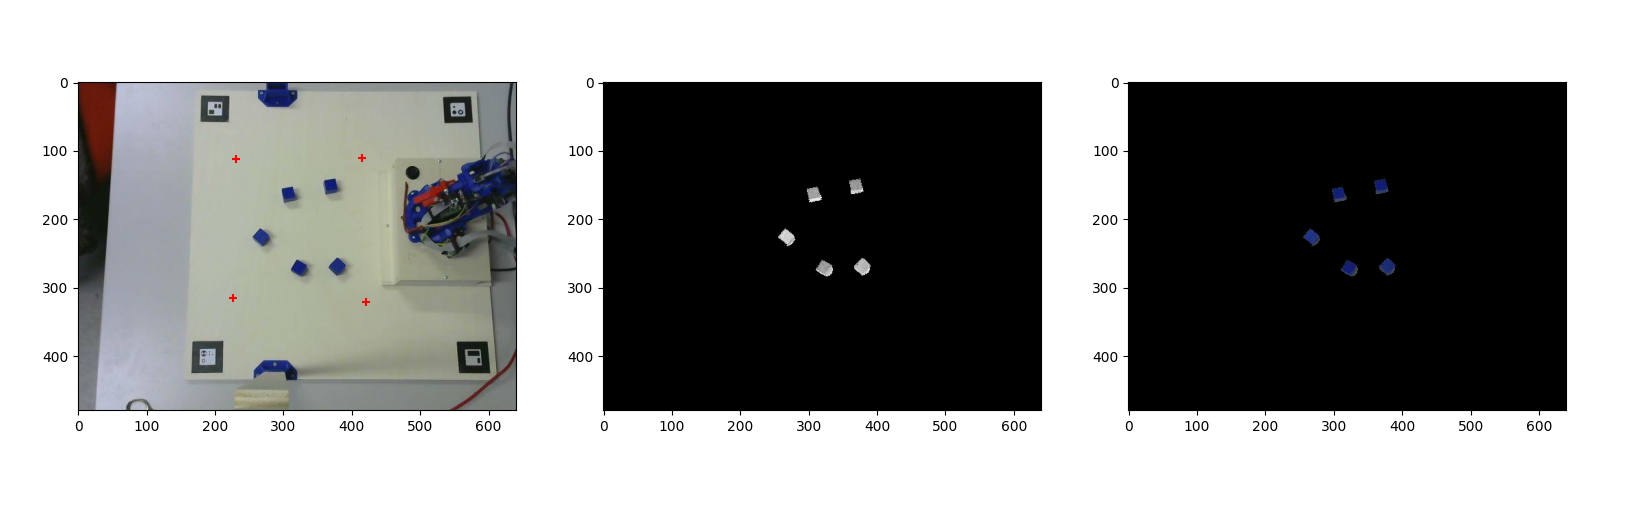

* Masko razdelite na posamezne komponente. Za vsako komponento izračunajte centroid, ki jih nato prikažite kot točke na izvorni sliki iz datoteke ``camera2.jpg``.

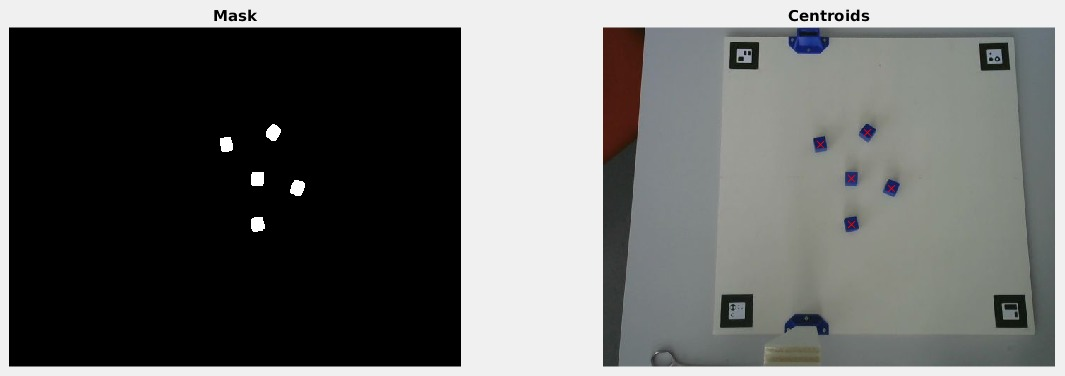

In [ ]:
from skimage import draw
import cv2
import manus
import numpy as np
import matplotlib.pyplot as plt
def poly2mask(y_coords, x_coords, shape):
    # y_coord = y koordinate poligona (vrstni red je pomemben!)
    # x_coord = x koordinate poligona (vrstni red je pomemben!)
    # shape = dimenzije maske (height, weight)
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask
def im_mask(I, mask):
    # Zapišite rešitev tukaj
    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0
    
    return I_masked
img = cv2.imread("camera2.jpg")
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape
print(shape)
plt.figure()
plt.subplot(131)
plt.imshow(im)
x = plt.ginput(4,show_clicks=True)
x_c = []
y_c = []
for i in x:
    x_c.append(i[0])
    y_c.append(i[1])
plt.scatter(x_c,y_c,marker="+", c="r")
mask = poly2mask(np.array(y_c),np.array(x_c),shape)

imm = im_mask(im,mask)

hsvImg = cv2.cvtColor(imm, cv2.COLOR_BGR2HSV)
imm=cv2.cvtColor(imm,cv2.COLOR_BGR2GRAY)
for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>90:
            imm[i][j]=0

plt.subplot(132)

ret,th1 = cv2.threshold(imm,0,100,cv2.THRESH_BINARY)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th1)

plt.imshow(imm,cmap="gray")
plt.subplot(133)
for i in range(3,len(centroids)):
    plt.scatter(centroids[i][0],centroids[i][1], color = "red")
plt.imshow(im)
plt.show()

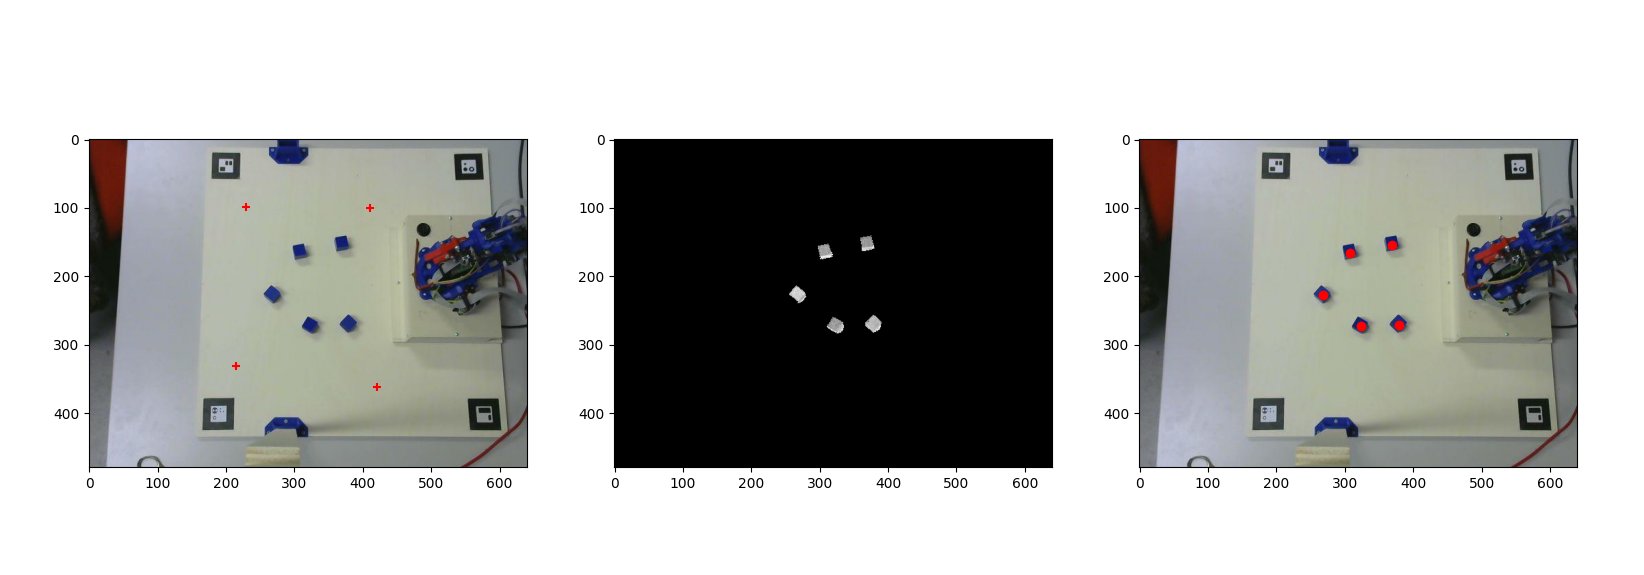

## Naloga 3 - Krmiljenje robotskega manipulatorja

Ta naloga združeje vse znanje pridobljeno tekom prvih treh nalog. Za to nalogo morate imeti vzpostavljno virtualno okolje za uporabo manipulatorja.

* Vzpostavite sistem za dostop do manipulatorja in kamere. Preučite skripto ``manus.py`` (osredotočite se predvsem na class *Camera* ter funkciji ``position`` in ``image``) in si oglajte spodaj priloženo kodo, ki demonstrira kako lahko iz kamere na robotskem manipulatorju pridobimo sliko ter jo prikažemo na zaslonu.

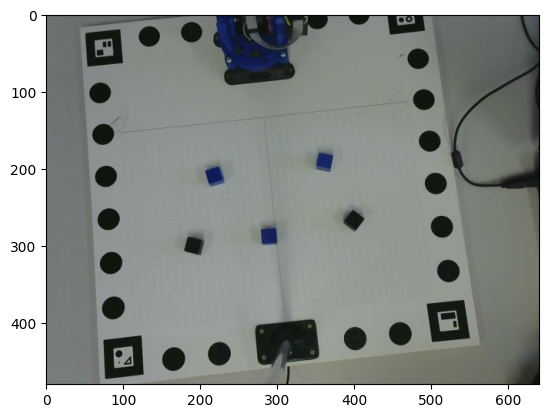

In [14]:
server = manus.Server(address='10.32.232.125', port=80)
#ip roka3: 10.32.232.119
camera = manus.Camera(server)
img = camera.image()
img_cl = cv2.cvtColor(img[0],cv2.COLOR_BGR2RGB)
#𝑝𝑆=[𝑥,𝑦,1],𝑝𝐻=𝐻∗𝑝𝑆=[𝑥𝐻,𝑦𝐻,𝑧𝐻],𝑝𝐷=[𝑥𝐻/𝑧𝐻,𝑦𝐻/𝑧𝐻]
#print(img)

plt.figure()
plt.imshow(img_cl)

* Z uporabo priložene funkcije ``get_homography_matrix`` preberite homografsko matriko. Homografsko matriko uporabite za izris kvadrata z $(x, y)$ koordinatami $(100, -200)$, $(100, 200)$, $(300, 200)$, $(300, -200)$ v svetovnem koordinatnem sistemu delovne ravnine.

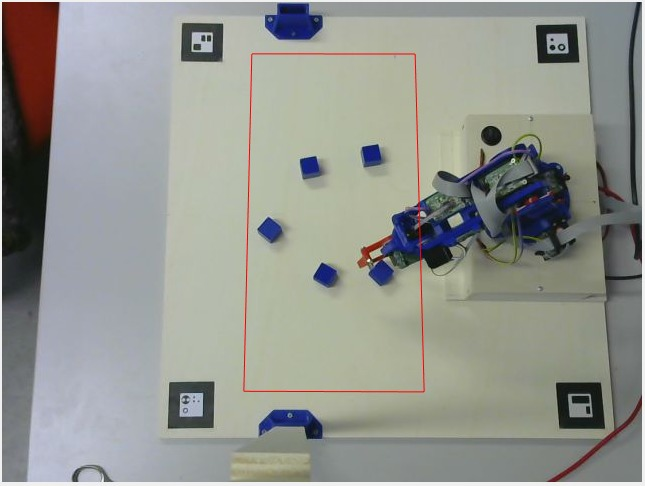

In [2]:
def get_homography_matrix(camera):
    camera_position = camera.position()
    intrinsics = camera.intrinsics
    rotation_matrix = camera_position[0]
    translation_vector = camera_position[1]
    
    transform = np.hstack((rotation_matrix, np.transpose(translation_vector)))
    projective = np.matmul(intrinsics, transform);
    homography = projective[:, [0, 1, 3]];
    homography /= homography[2, 2];
    
    return homography

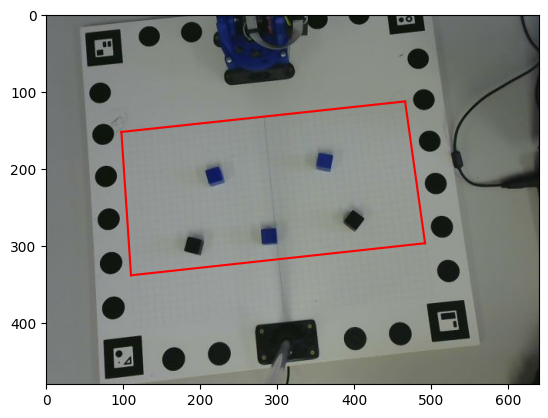

In [13]:
# TODO
#(100,−200) ,  (100,200) ,  (300,200) ,  (300,−200) 
server = manus.Server(address='10.32.232.125', port=80)
#ip roka3: 10.32.232.119
#𝑝𝑆=[𝑥,𝑦,1],𝑝𝐻=𝐻∗𝑝𝑆=[𝑥𝐻,𝑦𝐻,𝑧𝐻],𝑝𝐷=[𝑥𝐻/𝑧𝐻,𝑦𝐻/𝑧𝐻]
coords = [[100,-200],[100,200],[300,200],[300,-200]]
camera = manus.Camera(server)
img = camera.image()
img_cl = cv2.cvtColor(img[0],cv2.COLOR_BGR2RGB)
h_matrika = get_homography_matrix(camera)
y=[]
x=[]
for i in coords:
    ps = np.array([i[0],i[1],1])
    ph = np.dot(h_matrika,ps)
    pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
    x.append(pd[0])
    y.append(pd[1])   

plt.figure()

y2= [y[0],y[3]]
x2=[x[0],x[3]]
plt.plot(x[0:2],y[0:2],"r-")
plt.plot(x[2:4],y[2:4],"r-")
plt.plot(x[1:3],y[1:3],"r-")
plt.plot(x2,y2,"r-")
plt.imshow(img_cl)


plt.show()


* Skripto razširite tako, da bo na sliki zaznala modre kocke ter prikazala njihove centroide. Po potrebi lahko določite tudi masko delovne površine (ker je kamera v scenariju statična, lahko to masko določite enkrat ter jo potem uporabljate večkrat).

(480, 640)


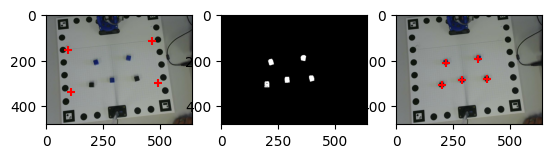

In [20]:
# TODO
from skimage import draw
import cv2
import time
import manus
import numpy as np
import matplotlib.pyplot as plt
def load_h(txt_file_path):
    with open(txt_file_path, 'r') as f:
        l = [[float(num) for num in line.split(',')] for line in f]    
    return np.array(l)
def poly2mask(y_coords, x_coords, shape):
    # y_coord = y koordinate poligona (vrstni red je pomemben!)
    # x_coord = x koordinate poligona (vrstni red je pomemben!)
    # shape = dimenzije maske (height, weight)
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask
def im_mask(I, mask):
    # Zapišite rešitev tukaj
    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0   
    return I_masked
server = manus.Server(address='10.32.232.125', port=80)
manipulator = manus.Manipulator(server)
camera = manus.Camera(server)
img_c=camera.image()
img = img_c[0]
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape
h = get_homography_matrix(camera)

print(shape)
plt.figure()
plt.subplot(131)
plt.imshow(im)
#x = plt.ginput(4,show_clicks=True)
x_c = []
y_c = []
#y_c = [-200,200,200,-200]
#x_c= [100,100,300,300]
coords = [[100,-200],[100,200],[300,200],[300,-200]]
coords2 = []
for i in coords:
    ps = np.array([i[0],i[1],1])
    ph = np.dot(h,ps)
    pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
    x_c.append(pd[0])
    y_c.append(pd[1]) 
    

#for i in x:
 #   x_c.append(i[0])
  #  y_c.append(i[1])
plt.scatter(x_c,y_c,marker="+", c="r")
mask = poly2mask(np.array(y_c),np.array(x_c),shape)
imm = im_mask(im,mask)
hsvImg = cv2.cvtColor(imm, cv2.COLOR_BGR2HSV)
imm=cv2.cvtColor(imm,cv2.COLOR_BGR2GRAY)
for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>120:
            imm[i][j]=0

plt.subplot(132)
kernel = np.ones((3, 3), np.uint8)
ret,th1 = cv2.threshold(imm,20,255,cv2.THRESH_BINARY)
th1=cv2.erode(th1, kernel, iterations=1)
th1 = cv2.dilate(th1, kernel, iterations=1)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th1)


plt.imshow(th1,cmap="gray")
plt.subplot(133)




for i in range(1,len(centroids)):
    if(centroids[i][0]>np.min(np.array(x_c)) and centroids[i][0]<np.max(np.array(x_c)) and centroids[i][1]>np.min(np.array(x_c)) and centroids[i][1]<np.max(np.array(x_c))):
        plt.scatter(centroids[i][0],centroids[i][1], color = "red",marker="+")

plt.imshow(im)
plt.show()

#server = manus.Server(address='10.32.232.119', port=80)
#ip roka3: 10.32.232.119
#𝑝𝑆=[𝑥,𝑦,1],𝑝𝐻=𝐻∗𝑝𝑆=[𝑥𝐻,𝑦𝐻,𝑧𝐻],𝑝𝐷=[𝑥𝐻/𝑧𝐻,𝑦𝐻/𝑧𝐻]

#camera = manus.Camera(server)
#img = camera.image()



* Preslikajte vse točke iz koordinatnega sistema kamere v koordinatni sistem delovne površine. V zanki potujte preko seznama točk ter manipulator premikajte tako, da bo s koncem prijemala pokazal na posamezni zaznani objekt na delovni površini. Ker v $3D$ prostoru robotskega manipulatorja zaznane točke ležijo na delovni površini (koordinata v smeri $z$ je $0$) kot take niso neposredno primerne za podajanje cilja robotskemu manipulatorju. Zato točko preoblikujte tako, da ji podate novo višino od delovne površine (npr. $z = 30$). Take točke bodo od ravnine oddaljene 3 cm.

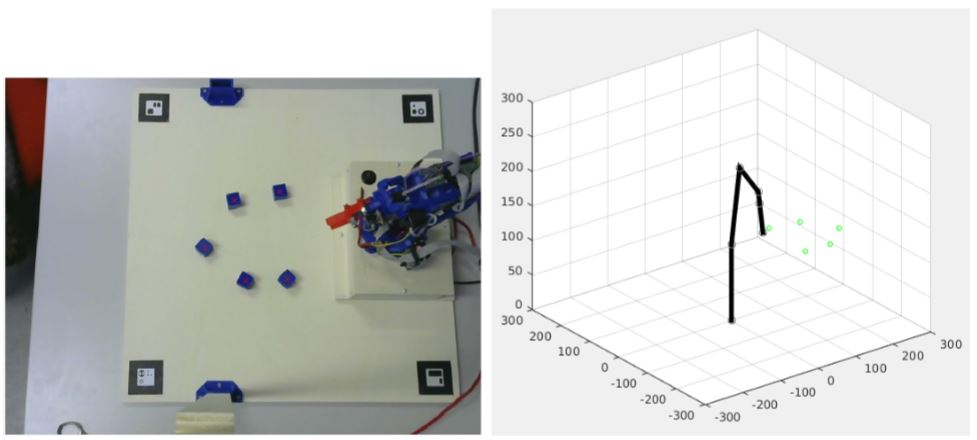

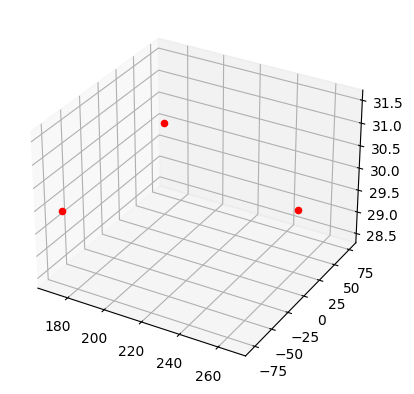

In [24]:
# TODO
from mpl_toolkits import mplot3d

from skimage import draw
import cv2
import time
import manus
import numpy as np
import matplotlib.pyplot as plt
def load_h(txt_file_path):
    with open(txt_file_path, 'r') as f:
        l = [[float(num) for num in line.split(',')] for line in f]    
    return np.array(l)
def poly2mask(y_coords, x_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask
def im_mask(I, mask):
    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0   
    return I_masked
server = manus.Server(address='10.32.232.125', port=80)
manipulator = manus.Manipulator(server)
camera = manus.Camera(server)
img_c=camera.image()
img = img_c[0]
safe_position = [0.0, 2.6179938316345215, -1.5707963705062866, -1.2217304706573486, 0.0, 0.0, 0.0]

im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape
h = get_homography_matrix(camera)
hi = np.linalg.inv(h)

x_c = []
y_c = []

coords = [[100,-200],[100,200],[300,200],[300,-200]]
coords2 = []


for i in coords:
    
        ps = np.array([i[0],i[1],1])
        ph = np.dot(h,ps)
        pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
        x_c.append(pd[0])
        y_c.append(pd[1]) 


mask = poly2mask(np.array(y_c),np.array(x_c),shape)
imm = im_mask(im,mask)
hsvImg = cv2.cvtColor(imm, cv2.COLOR_BGR2HSV)
imm=cv2.cvtColor(imm,cv2.COLOR_BGR2GRAY)
for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>120:
            imm[i][j]=0



kernel = np.ones((3, 3), np.uint8)
ret,th1 = cv2.threshold(imm,20,255,cv2.THRESH_BINARY)
th1=cv2.erode(th1, kernel, iterations=1)
th1 = cv2.dilate(th1, kernel, iterations=1)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th1)

for i in range(1,len(centroids)):
        ps = np.array([centroids[i][0],centroids[i][1],1])
        ph = np.dot(hi,ps)
        pd = [ph[0]/ph[2],ph[1]/ph[2],30]
        coords2.append(pd)
states=[]

fig = plt.figure()
ax = plt.axes(projection='3d')
for i in coords2:
    ax.scatter(i[0], i[1], i[2], color='red');

for i in coords2:
    state=[]
    state = manipulator.solve(i)
    states.append(state)
#manipulator.move(states[0])
#time.sleep(1)
#manipulator.move(safe_position)

for i in states:
    manipulator.move(i)
    time.sleep(2)
    manipulator.move(safe_position)


* Razširite detekcijo objektov tako, da bo zaznala kocke dveh barv, modre in črne. Manipulator naj nato pokaže vse zaznane modre kocke z zaprtim prijemalom, nato pa še črne kocke z odprtim prijemalom.

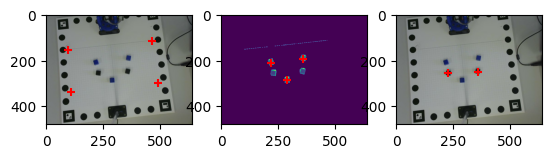

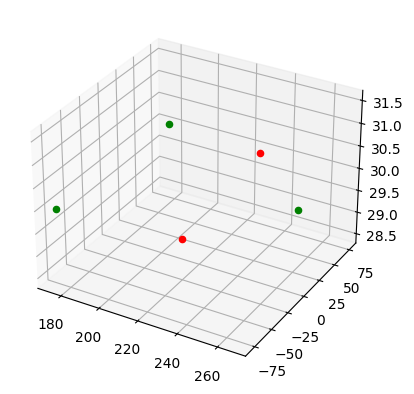

In [23]:
from skimage import draw
import cv2
import manus
import numpy as np
import matplotlib.pyplot as plt
def poly2mask(y_coords, x_coords, shape):

    fill_row_coords, fill_col_coords = draw.polygon(y_coords, x_coords, shape)
    mask = np.zeros(shape, dtype=bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask
def im_mask(I, mask):

    I_masked = np.copy(I)
    
    for i in range(1,len(I)):
        for j in range(1,len(I[i])):
            if mask[i][j]==0:
                I_masked[i][j][0]=0
                I_masked[i][j][1]=0
                I_masked[i][j][2]=0
    
    return I_masked
kernel = np.ones((3, 3), np.uint8)
server = manus.Server(address='10.32.232.125', port=80)
manipulator = manus.Manipulator(server)
camera = manus.Camera(server)
h = get_homography_matrix(camera)
img_c=camera.image()
img = img_c[0]
im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
shape = imgr.shape

plt.figure()
plt.subplot(131)
plt.imshow(im)
hi = np.linalg.inv(h)
x_c = []
y_c = []

coords = [[100,-200],[100,200],[300,200],[300,-200]]
coords2 = []
for i in coords:
        ps = np.array([i[0],i[1],1])
        ph = np.dot(h,ps)
        pd = np.array([ph[0]/ph[2],ph[1]/ph[2]])
        x_c.append(pd[0])
        y_c.append(pd[1]) 


plt.scatter(x_c,y_c,marker="+", c="r")
mask = poly2mask(np.array(y_c),np.array(x_c),shape)

imm = im_mask(im,mask)

hsvImg = cv2.cvtColor(imm, cv2.COLOR_BGR2HSV)
imm=cv2.cvtColor(imm,cv2.COLOR_BGR2GRAY)
imm_b=np.copy(imm)

for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>35:
            imm_b[i][j]=0
        else:
            imm_b[i,j]=imm[i,j]

for i in range(0,len(imm)):
    for j in range(0,len(imm[i])):
        if imm[i][j]>120:
            imm[i][j]=0        
plt.subplot(132)

ret,th1 = cv2.threshold(imm_b,0,55,cv2.THRESH_BINARY)
th1=cv2.erode(th1, kernel, iterations=1)
th1 = cv2.dilate(th1, kernel, iterations=1)
ret2,th2 = cv2.threshold(imm,0,55,cv2.THRESH_BINARY)
th2=cv2.erode(th2, kernel, iterations=1)
th2 = cv2.dilate(th2, kernel, iterations=1)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th1)
num_labels2, labels2, stats2, centroids2 = cv2.connectedComponentsWithStats(th2)
f =False
blu_man = []
blk_man = []
for i in range(1,len(centroids2)):
    for j in range(1,len(centroids)):
        if(abs(centroids2[i][0]-centroids[j][0])<10 and abs(centroids2[i][1]-centroids[j][1])<10):
            f = True
    if f:
        f=False
        continue
    plt.scatter(centroids2[i][0],centroids2[i][1], color = "red",marker="+")
    blu_man.append([centroids2[i][0],centroids2[i][1]])

plt.imshow(imm)

plt.subplot(133)
for i in range(1,len(centroids)):
    plt.scatter(centroids[i][0],centroids[i][1], color = "red",marker="+")
    blk_man.append([centroids[i][0],centroids[i][1]])
for i in range(0,len(blk_man)):
        ps = np.array([blk_man[i][0],blk_man[i][1],1])
        ph = np.dot(hi,ps)
        pd = [ph[0]/ph[2],ph[1]/ph[2],30]
        coords2.append(pd)
coords3=[]
for i in range(0,len(blu_man)):
        ps = np.array([blu_man[i][0],blu_man[i][1],1])
        ph = np.dot(hi,ps)
        pd = [ph[0]/ph[2],ph[1]/ph[2],30]
        coords3.append(pd)
states_blu=[]
states_blk=[]

safe_position_o = [0.0, 2.6179938316345215, -1.5707963705062866, -1.2217304706573486, 0.0, 0.0, 0.0]
safe_position_c = [0.0, 2.6179938316345215, -1.5707963705062866, -1.2217304706573486, 0.0, 0.0, 2.0]
for i in coords2:
    state=[]
    state = manipulator.solve(i)
    states_blk.append(state)
for i in coords3:
    state=[]
    state = manipulator.solve(i)
    state[len(state)-1]=2
    states_blu.append(state)

for i in states_blu:
    manipulator.move(i)
    time.sleep(2)
    manipulator.move(safe_position_c)
for i in states_blk:
    manipulator.move(i)
    time.sleep(2)
    manipulator.move(safe_position_o)
    
plt.imshow(im)
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in coords2:
    ax.scatter(i[0], i[1], i[2], color='red');
for i in coords3:
    ax.scatter(i[0], i[1], i[2], color='green');
plt.show()

* **(5 točk)** Napišite algoritem, ki bo krmilil manipulator tako, da bo sledil izbranemu predmetu preko kamere. Pri tem lahko predpostavite, da je predmet blizu delovne površine (z = 0), lahko si tudi izberete njegovo barvo ali druge lastnosti.

In [ ]:
# TODO

* **(10 točk)** Prilagodite algoritem iz prejšnjih točk tako, da bo manipulator zaznane kocke dveh barv (si lahko izberete vnaprej), ki so na začetku razporejene naključno, razporedil glede na barvo na levo in desno stran delovne površine. Pri tem bodite pozorni, da kocke ne bodo postavljene ena čez drugo.

In [ ]:
# TODO

* **(10 točk)** Prilagodite algoritem iz prejšnjih točk tako, da bo manipulator zaznane kocke (vsaj štiri kocke) zložil eno na drugo v stolp. 